# This notebook computes all the features assortments on the GYAC corpus

In [9]:
##IMPORTATIONS

import numpy as np
import nltk
import joblib as jbl
import os
import pickle as pk
import readability
import time

import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
import gensim

from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_extraction.text import CountVectorizer

import spacy, collections, readability

from textblob import TextBlob
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk import ne_chunk, pos_tag, ngrams, tokenize
from pickle import dump, load
from nltk.parse import CoreNLPParser
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

D:\ProgramFiles\Anaconda\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Pre-processing of the e-mails: convert into a list of sentence list

In [2]:
def extract_text_content(html_file):
    file = open(html_file, 'r', encoding = 'utf-8')
    soup = BeautifulSoup(file)        
    for script in soup(["script", "style"]):
        script.decompose()
    strips = list(soup.stripped_strings)
    return strips 


def process_emails(html_dir): ##input is the path to the html directory containing all of the html files
    global_list = []
    html_files_path = [x for x in os.listdir(html_dir) if 'html' in x]
    for html_file in html_files_path:
        sent_list = extract_text_content(html_dir + "/"+html_file)
        sent_list = ' '.join(sent_list)
        sent_list = nltk.tokenize.sent_tokenize(sent_list)
        global_list.append(sent_list)
    return global_list


In [3]:
html_directory = "emails"
emails_sentlist = process_emails(html_directory)

In [4]:
print(emails_sentlist)

#FINAL RESULT: A list of list. Each element contains the sentences from 1 e-mail.

[['April Offer - Especially for You from The Inn 😍 April Offer from The Inn - Dinner Bed & Breakfast View in browser ACCOMMODATION DINING EVENTS Dear Sandra The Inn on Loch Lomond £89 Dinner Bed & Breakfast Offer Stay in April for £89 - per room per night inclusive of dinner bed & breakfast - Loch Lomond or Glen Douglas Rooms .', 'Upgrade your room from £30 or stay on the weekend for a supplement of £30 for a Friday and £50 for a Saturday.', 'As we look forward to some better weather, treat yourself to a little break at The Inn!', 'Take a wander along the loch side or for the more adventurous perhaps one of the local hill walks where you can enjoy the wonderful spring scenery.', 'Later you can relax in the bar for some pre dinner drinks before heading into the Restaurant to sample some fabulous dinner dishes .', "You could always add on a visit to the leisure facilities at our sister property The Lodge on Loch Lomond and don't forget the Folk Sessions every weekend - a great line up of

## Functions used to compute the features assortment

### 1st assortment: linguistic features

In [2]:
##Intermediary functions

def get_case(string):
    """
    return a number list containing: the number of entirely-capitalized words; binary indicator for whether sentence
    is lowercase; binary indicator for whether the first word is capitalized.
    """
    return [len([w for w in word_tokenize(string) if w.isupper()]), int(string.islower()), int(string[0].isupper())]

def get_lexical(string):
    """
    return the number of contractions in the sentence, normalized by length; average word length; average word
    log-frequency according to Google Ngram corpus; average formality score as computed by Pavlick and
    Nenkova (2015).
    """
    # prepare
    output = []
    tokens = word_tokenize(string.lower())
    length = len(tokens)

    # 1. number of contractions, norm by length
    cont_count = 0
    for w in tokens:
        if "\'" in w and len(w) > 1:
            cont_count += 1
    output.append(round(cont_count/length, 2))

    # 2. average word length
    output.append(round(sum([len(w) for w in tokens])/length, 2))
    
    return output
    
def get_punctuation_number(string):
    """
    punctuation Number of ‘?’, ‘...’, and ‘!’ in the sentence.
    """
    punct_number = 0
    tokens = word_tokenize(string)

    for w in tokens:
        if w in ["?", "...", "!", ";"]:
            punct_number += 1
    return [punct_number]


## Final function gathering all those stats and computing them on a sentence level

def get_linguistic_features_sentence(string):
    # get the easier-to-compute features
    output = []
    # 3 nums
    output.extend(get_case(string))
    # 2 nums
    output.extend(get_lexical(string))
    # 1 num
    output.extend(get_punctuation_number(string))

    # total of 6 nums per input sentence
    return output

##FINAL FUNCTION that gets applied on an e-mail level (list of sentences)

def get_linguistic_features_all(sent_list):
    """
    return an array of an array of features for the total sentence list
    """
    # get list of raw number stats for each sentence
    num_lists = []
    for s in sent_list:
        num_lists.append(get_linguistic_features_sentence(s))
    # list into vec array
    output = np.array(num_lists)
    return output


In [6]:
## TEST OF FUNCTIONS

test_string = "I do not approve of this dissertation, it absolutely sucks !"
print(f"get_case returns: {get_case(test_string)}")
print(f"get_lexical returns: {get_lexical(test_string)}")
print(f"get_punctuation_number returns: {get_punctuation_number(test_string)}")

get_case returns: [1, 0, 1]
get_lexical returns: [0.0, 4.17]
get_punctuation_number returns: [1]


### 2nd assortment: readability and sentiment features

In [7]:
###IMPORTATION OF THE WORD LISTS 
HEDGE_WORDS = "largely generally often rarely sometimes frequently occasionally seldom usually most several some almost practically apparently virtually basically approximately roughly somewhat somehow partially actually like something someone somebody somewhere think thinks thought believe believed believes consider considers considered assume assumes assumed understand understands understood find found finds appear appears appeared seem seems seemed suppose supposes supposed guess guesses guessed estimate estimates estimated speculate speculates speculated suggest suggests suggested may could should might surely probably likely maybe perhaps unsure probable unlikely possibly possible read say says looks like look like don't know necessarily kind of much bunch couple few little really and all that and so forth et cetera in my mind in my opinion their impression my impression in my understanding my thinking is my understanding is in my view if i'm understanding you correctly something or other so far at least  about around can effectively evidently fairly hopefully in general mainly more or less mostly overall presumably  pretty quite clearly quite rather sort of supposedly  tend appear to be doubt be sure indicate will must would certainly definitely clearly conceivably certain definite clear assumption possibility probability  many almost never improbable always rare consistent with doubtful suggestive diagnostic inconclusive apparent alleged allege a bit presumable".split()
FIRST_PERSON_PRONOUNS = ['I', 'me', 'my', 'mine', 'we', 'us', 'our', 'ours', 'my', 'mine', 'our', 'ours']
THIRD_PERSON_PRONOUNS = ['he', 'she', 'it', 'one', 'they', 'him', 'her', 'it', 'one', 'them', 'his', 'hers', 'theirs', 'himself', 'herself', 'itself', 'oneself', 'themselves']

In [8]:

def get_readability(text):
    """
    return the length of the sentence, in words and characters; Flesch-readability ease score.
    """
    try:
        blob = TextBlob(text)
        results = readability.getmeasures(text, lang='en')
        return [len(blob.words), len(text), round(results['readability grades']['FleschReadingEase'], 2)]
    except ValueError:
        return [len(blob.words), len(text),100]


def get_subjectivity_features(text):
    """
    return number of passive constructions; number of hedge words, according to a word list; number of 1st
    person pronouns; number of 3rd person pronouns; subjectivity according to the TextBlob sentiment
    module; binary indicator for whether the sentiment is positive or negative, according to TextBlob
    
    The subjectivity is a float within the range [0.0, 1.0], from most objective (0) to most subjective (1)
    """
    res = []
    blob = TextBlob(text)
    
    def get_passive_count(text):
        nlp = spacy.load("en_core_web_sm")
        doc = nlp(text)
        count = 0
        for tok in doc:
            if tok.dep_.find("subjpass") == True:
                count += 1
        return count
    
    def get_count(word_list):
        count = 0
        for word in word_list:
            count += blob.words.count(word)
        return count 
    
    length = len(blob.words)
    if length!=0:
        #res.append(round(get_passive_count(text)/length, 2))
        res.append(round(get_count(HEDGE_WORDS)/length, 2))
        res.append(round(get_count(FIRST_PERSON_PRONOUNS)/length, 2))  
        res.append(round(get_count(THIRD_PERSON_PRONOUNS)/length, 2))
        #res.append([0,1][blob.sentiment.polarity>=0])
        res.append(round(blob.sentiment.subjectivity, 2))
    else:
        res = [0,0,0,round(blob.sentiment.subjectivity, 2)]
        
    return res

## Final function gathering all those stats and computing them on a sentence level

def get_readability_features_sentence(string):
    output = []
    output.extend(get_readability(string))
    output.extend(get_subjectivity_features(string))
    # total of 9 nums per input sentence
    return output

def get_readability_features_all(sent_list):
    """
    return an array of an array of features for the total sentence list
    """
    # get list of raw number stats for each sentence
    num_lists = []
    for s in sent_list:
        num_lists.append(get_readability_features_sentence(s))
    # list into vec array
    output = np.array(num_lists)
    return output
    

In [9]:
## TEST OF FUNCTIONS

test_string = ":( :( :( :( )"
blob = TextBlob(test_string)
print(blob.sentiment.subjectivity)
print(len(blob.words))
print(f"get_readability returns: {get_readability(test_string)}")

test_string2 = "This dissertation is wonderful, I've never seen anything like it before!"
print(f"get_readability returns: {get_readability(test_string2)}")
print(f"get_subjectivity_features returns: {get_subjectivity_features(test_string2)}")

1.0
0
get_readability returns: [0, 13, 100]
get_readability returns: [12, 72, 60.71]
get_subjectivity_features returns: [0.5, 0.08, 0.17, 1.0]


### 3rd features assortment: entity-related (grammatical role)

In [10]:
def get_pos_features_sentence(string):
    """
    return POS Number of occurrences of each POS tag, as well as the average length of the words for each POS family.
    
    """
    interesting_tags=["N","JJ","IN","RB","VB"]
    tags_counts = [0,0,0,0,0]
    tags_avg_lengths = [0,0,0,0,0]
    for word, tag in pos_tag(word_tokenize(string)):
        if 'N' == tag[0]:
            tags_counts[0]+=1
            tags_avg_lengths[0]+=len(word)
        else:
            for i in range(1,len(interesting_tags)):
                pos_family = interesting_tags[i]
                if pos_family == tag[0:2]:
                    tags_counts[i]+=1
                    tags_avg_lengths[i]+=len(word)
                    break
    tags_avg_lengths = [tags_avg_lengths[i]/tags_counts[i] if tags_counts[i]!=0 else 0 for i in range(len(tags_avg_lengths))]          
    return tags_counts + tags_avg_lengths


def get_pos_features_all(sent_list):
    """
    return an array of an array of features for the total sentence list
    """
    # get list of raw number stats for each sentence
    num_lists = []
    for s in sent_list:
        num_lists.append(get_pos_features_sentence(s))
    # list into vec array
    output = np.array(num_lists)
    return output

In [11]:
## TEST OF FUNCTIONS

test_string = "I think this dissertation could take a little improvement, particularly when looking at the vocabulary used."
res = get_pos_features_sentence(test_string)
print(res)

[3, 1, 1, 1, 4, 11.0, 6.0, 2.0, 12.0, 5.0]


In [12]:
corpus_dict = pk.load(open('corpus_dict.pk','rb'))
corpus_sent_list = []
corpus_sent_list.extend(corpus_dict["formal"])
corpus_sent_list.extend(corpus_dict["informal"])

## Extraction of the 3 features assortments on the GYAC training corpus of 110k sentences

In [50]:
def extract_all_features_assortments(corpus_file_name):
    corpus_dict = pk.load(open(corpus_file_name,'rb'))
    corpus_sent_list = []
    corpus_sent_list.extend(corpus_dict["formal"])
    corpus_sent_list.extend(corpus_dict["informal"])
    
    print("Extracting POS-related features....")
    try: 
        pos_features_corpus = pk.load(open('pos_features.pk','rb'))
    except FileNotFoundError:
        pos_features_corpus = get_pos_features_all(corpus_sent_list)  
        #pk.dump(pos_features_corpus, open('pos_features.pk','wb'))
    print("End of the extraction of POS-related features!")
    
    print("Extracting readability features....")
    try:
        read_features_corpus = pk.load(open('readability_features.pk','rb'))
    except FileNotFoundError:    
        read_features_corpus = get_readability_features_all(corpus_sent_list)
        #pk.dump(read_features_corpus,open('readability_features.pk','wb'))
    print("End of the extraction of readability features!")
        
    
    print("Extracting linguistic features....")
    try:
        linguistic_features_corpus=pk.load(open('linguistic_features.pk','rb'))
    except FileNotFoundError:
        linguistic_features_corpus = get_linguistic_features_all(corpus_sent_list)        
        #pk.dump(linguistic_features_corpus, open('linguistic_features.pk','wb'))
    print("End of the extraction of linguistic features!")
    
    return "EXTRACTION FINISHED!"
    

In [48]:
extract_all_features_assortments('corpus_dict.pk')

Extracting POS-related features....
End of the extraction of POS-related features!
Extracting readability features....
End of the extraction of readability features!
Extracting linguistic features....
End of the extraction of linguistic features!


'EXTRACTION FINISHED!'

### computation of the features arrays for the e-mails

In [13]:
test_sentence = "I love this blue car, it is simply great!"
print(f"linguistic features: {get_linguistic_features_sentence(test_sentence)}")
print(f"readability features: {get_readability_features_sentence(test_sentence)}")
print(f"POS-tagsfeatures: {get_pos_features_sentence(test_sentence)}")


linguistic features: [1, 0, 1, 0.0, 3.0, 1]
readability features: [9, 41, 113.1, 0.22, 0.11, 0.22, 0.48]
POS-tagsfeatures: [2, 1, 0, 1, 2, 3.5, 5.0, 0, 6.0, 3.0]


In [10]:
def extract_ling_stats_features(sent_list):
    res = []
    for sent in sent_list:
        res.append(get_linguistic_features_sentence(sent))
    res = np.array(res)
    return res



In [11]:
##TEST OF FUNCTIONS

sent_list_test = ["I do not approve of this terrible dissertation, it absolutely sucks !", 
                  "I love this blue car, it is simply great.", 
                  "The mitochondria is the powerhouse of the cell."]

test_stats = extract_ling_stats_features(sent_list_test)
print(test_stats)


[[1.   0.   1.   0.   4.46 1.  ]
 [1.   0.   1.   0.   3.   0.  ]
 [0.   0.   1.   0.   4.44 0.  ]]


In [12]:
## Loading the trained model
DT_emails = jbl.load("model/fast_number_dt.jbl")

FileNotFoundError: [Errno 2] No such file or directory: 'model/fast_number_dt.jbl'

In [10]:
test_res = DT_emails.predict_proba(test_stats)
test_res

array([[1.        , 0.        ],
       [0.74636364, 0.25363636],
       [0.88764045, 0.11235955]])

In [11]:
test_res.mean(axis=0)

array([0.87800136, 0.12199864])

In [12]:
def prediction_proba_emails(emails_sent_list, DT):
    results = []
    for email in emails_sent_list:
        title = email[0]
        features = extract_ling_stats_features(email)
        proba_arrays = DT.predict_proba(features) ##the array of the prediction probabilities for every sentence
        results.append((title, proba_arrays.mean(axis=0)))
    return results

In [13]:
final_preds = prediction_proba_emails(emails_sentlist, DT_emails)
final_preds

[('April Offer - Especially for You from The Inn 😍 April Offer from The Inn - Dinner Bed & Breakfast View in browser ACCOMMODATION DINING EVENTS Dear Sandra The Inn on Loch Lomond £89 Dinner Bed & Breakfast Offer Stay in April for £89 - per room per night inclusive of dinner bed & breakfast - Loch Lomond or Glen Douglas Rooms .',
  array([0.56355941, 0.43644059])),
 ('BLACK FRIDAY - 40% OFF & PAY WHEN YOU STAY Black Friday - Save 40% BOOK NOW With 40% off, enjoy a winter break and look forward to great Scottish escapes in 2021.',
  array([0.78280326, 0.21719674])),
 ('Easter Getaways Plumlocations Easter Breaks View in browser Hi Steve, After the pressure of another lockdown and for many home-schooling what better way to start looking forward to some hope by booking a Spring Getaway from 17th May.',
  array([0.74150714, 0.25849286])),
 ('Festive Celebrations and Year Round Breaks Festive celebrations and year round breaks View in browser Festive celebrations and year round breaks at Th

In [14]:
### WRONG: consider that every sentence from an informal document is in fact informal. 

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

y = [ x[1][0] for x in final_preds]

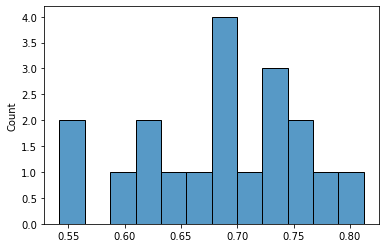

In [16]:
sns.histplot(y, bins = 12)
plt.xlabel = "Formality score"